# Predicting Sales Rossman Store Sales

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AutoReg
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')
%matplotlib inline

## Create DataFrame

In [3]:
sales = pd.read_csv('~/Downloads/rossmann-store-sales/train.csv')
sales = sales.set_index(pd.to_datetime(sales['Date'])).drop('Date', axis =1)
sales = sales[::-1] #To reverse the order.
sales

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1111,2,0,0,0,0,a,1
...,...,...,...,...,...,...,...,...
2015-07-31,5,5,4822,559,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1


In [225]:
store5_sales = sales[(sales['Store'] == 5)]
store5_sales = store5_sales[['Sales']]
store5_sales.head(30)

,Sales
Date,
2013-01-01,0
2013-01-02,4253
2013-01-03,3465
2013-01-04,4456
2013-01-05,1590
2013-01-06,0
2013-01-07,6978
2013-01-08,5718
2013-01-09,5974


- Above I have created a dataframe focusing on the sales for store # 5. I will use the historical data to predict 90 days of sales.

## Review of Data Structures

In [5]:
store5_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   942 non-null    int64
dtypes: int64(1)
memory usage: 14.7 KB


In [6]:
store5_sales.isnull().sum()

Sales    0
dtype: int64

In [7]:
store5_sales.describe()

,Sales
count,942.000000
mean,3867.110403
std,2389.609890
min,0.000000
25%,2027.000000
50%,4180.000000
75%,5419.250000
max,11692.000000


array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

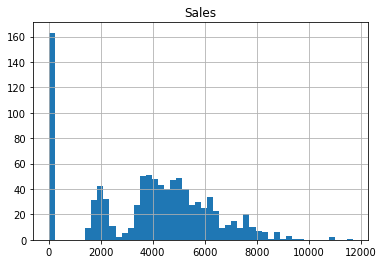

In [8]:
store5_sales.hist(bins = 50)

- No null data.
- There seems to be alot of zero sales. This must be attributed to weekend/holiday store closure.
- The data otherwise seems very flat with a lot of variance.
- The distribution is also skewed to the right.
- The minimum sale is 0 and the maximum is 11692.
- The store is closed every Sunday. Therefore, there is an underlying seasonal pattern that every 7th day there are zero sales. I will have period = 7 for my time series decomposition and forecast modeling.

# Data Visualization & Seasonal Decomposition

Text(0.5, 0, 'Date')

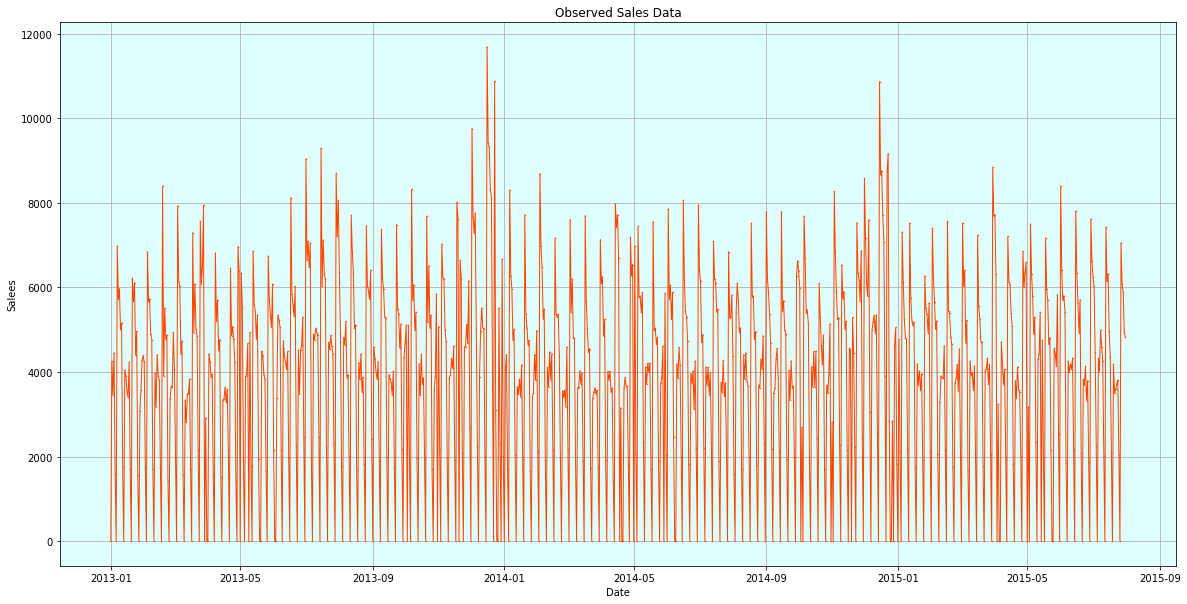

In [9]:
fig= plt.figure(figsize = (20, 10))
ax = fig.add_subplot()
ax.set_facecolor('lightcyan')

plt.plot(store5_sales,'.-',
        markerfacecolor='gold',
        markersize=1,
        linewidth=1,
        color='orangered')

plt.grid()
plt.title('Observed Sales Data')
plt.ylabel('Salees')
plt.xlabel('Date')

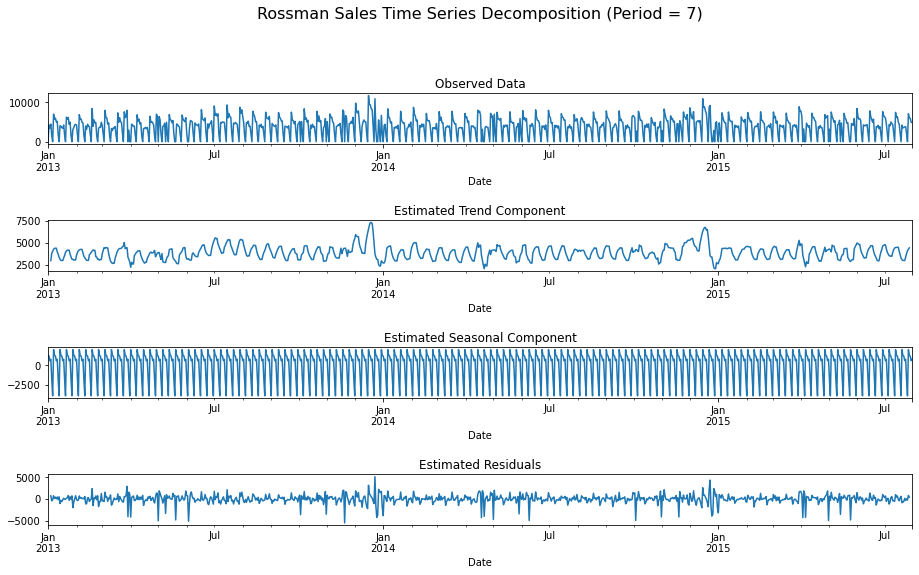

In [149]:
decomposition = seasonal_decompose(store5_sales, period = 7)
fig, (ax0, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,15))
decomposition.observed.plot(ax=ax0)
decomposition.trend.plot(ax=ax1)
decomposition.seasonal.plot(ax=ax2)
decomposition.resid.plot(ax=ax3)
fig.suptitle("Rossman Sales Time Series Decomposition (Period = 7)", fontsize=16)
ax = plt.subplot(ax0)
ax.set_title("Observed Data")
ax = plt.subplot(ax1)
ax.set_title("Estimated Trend Component")
ax = plt.subplot(ax2)
ax.set_title("Estimated Seasonal Component")
ax = plt.subplot(ax3)
ax.set_title("Estimated Residuals")
plt.subplots_adjust(left=0.1,
                    bottom=0.5, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=1.5)
plt.show()

Above the estimated seasonal component strongly suggests a predictable pattern and reinforces the premise that the time-series is not stationary.

### Stationary Statistical Testing

In [11]:
ad_fuller_result = adfuller(store5_sales, autolag = 'AIC')
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print(f'n_lags: {ad_fuller_result[2]}')
print(f'nobs:{ad_fuller_result[3]}')
for key, value in ad_fuller_result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -5.2250881457262945
p-value: 7.812279185012506e-06
n_lags: 20
nobs:921
Critical Values:
   1%, -3.437470108019385
Critical Values:
   5%, -2.8646832620852853
Critical Values:
   10%, -2.5684436698650503


In [12]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
kpss_test(store5_sales)

KPSS Statistic: 0.11499588513461094
p-value: 0.1
num lags: 22
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


Both the ADF & KPSS statistical tests find that the time series is stationary

## Autocorrelation & Partial Correlation

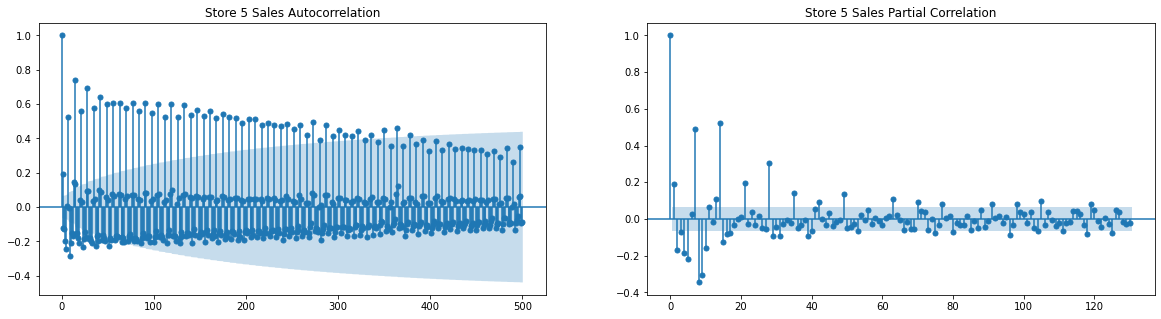

In [127]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
plot_acf(store5_sales, lags = 500, ax = ax[0])
ax[0].set_title('Store 5 Sales Autocorrelation')
plot_pacf(store5_sales, lags = 130, ax = ax[1])
ax[1].set_title('Store 5 Sales Partial Correlation');

- The correlation plots above give me the impression that both seasonal and non-seasonal integration parameters are higher than 1 and if I am reading them correctly (the number of lags before it decays to 0) then both are 5. However, this would create a very complex model. Therefore, I will apply a value of 0 and 1 to both of these parameters.

- Since both statistical tests confirm that data is stationary, I will continue but the statistical tests (the KPSS nearly rejected the null hypothesis) and plots (the autocorrelation plot does not entirely decay to 0) lead me to believe that there may be a gray zone between stationary and non-stationary. Especially since the original data and the decomposed estimated seasonal plot strongly suggest a seasonal pattern and, therfore, non-stationarity.

- I returned these autocorrelation and partial correlation plots and increased their lags to 500 and 130, respectively. Both plots do ultimately decay to 0

## History/Future Sales Split

In [71]:
sales_hist, sales_future = store5_sales[:-90], store5_sales.iloc[-90:]
sales_hist

,Sales
Date,
2013-01-01,0
2013-01-02,4253
2013-01-03,3465
2013-01-04,4456
2013-01-05,1590
...,...
2015-04-28,6012
2015-04-29,6366
2015-04-30,6598


In [224]:
sales_future.head(30)

,Sales
Date,
2015-05-03,0
2015-05-04,7503
2015-05-05,6315
2015-05-06,5795
2015-05-07,4897
2015-05-08,5301
2015-05-09,2354
2015-05-10,0
2015-05-11,4305


## Modeling & Optimization

- Here I will use a function that will test different parameters for the SARIMAX model. This function will create a table with the best performing model. I will also input seasonal parameter as 0 and non-seasonal integration parameters to be 1 and period will be 7 due to the store being closed every Sunday.

In [226]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [227]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 7
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

16


In [203]:
result_df = optimize_SARIMA(parameters_list, 0, 1, 7, sales_hist['Sales'])
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 1, 1)",14606.149250
1,"(1, 0, 1, 1)",14621.763917
2,"(1, 1, 0, 1)",14639.846620
3,"(0, 1, 1, 1)",14640.477726
4,"(1, 0, 0, 1)",14655.386360
5,"(0, 1, 0, 1)",14682.480130
6,"(0, 0, 1, 1)",14695.072590
7,"(0, 0, 0, 1)",14766.788213
8,"(1, 1, 1, 0)",14808.655837
9,"(1, 0, 1, 0)",14822.673812


The above table demonstrates a significant difference in the AIC score given a p,q, P, Q values of 1,0,1,0 respectfully.

In [204]:
model = SARIMAX(sales_hist['Sales'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 7)).fit(dis=-1)
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  852
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -7298.075
Date:                           Sun, 07 Aug 2022   AIC                          14606.149
Time:                                   06:34:41   BIC                          14629.846
Sample:                               01-01-2013   HQIC                         14615.229
                                    - 05-02-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6685      0.053     12.594      0.000       0.564       0.773
ma.L1         -0.3863      0.060     -6.404

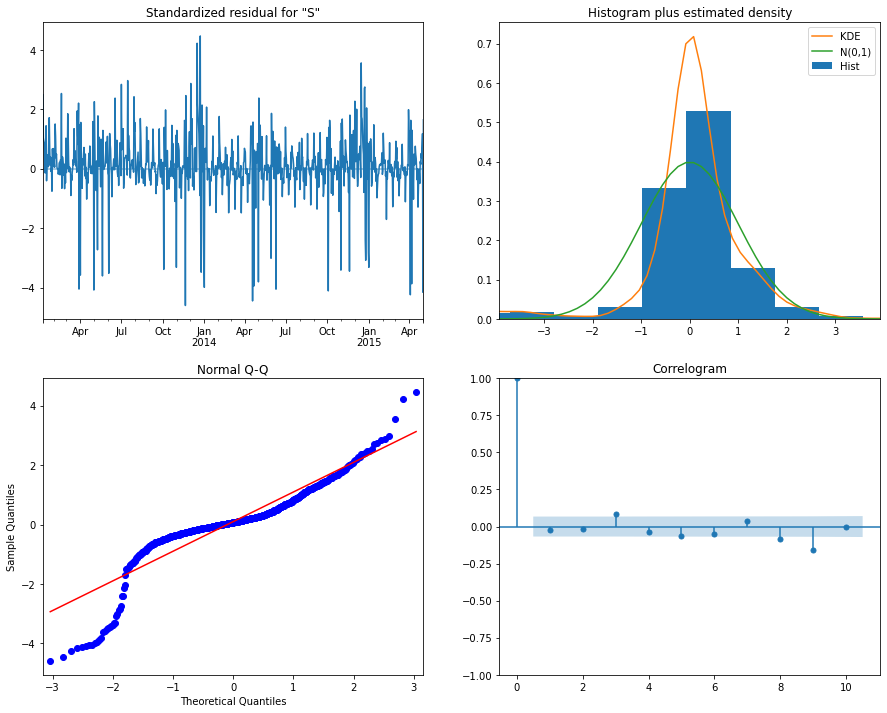

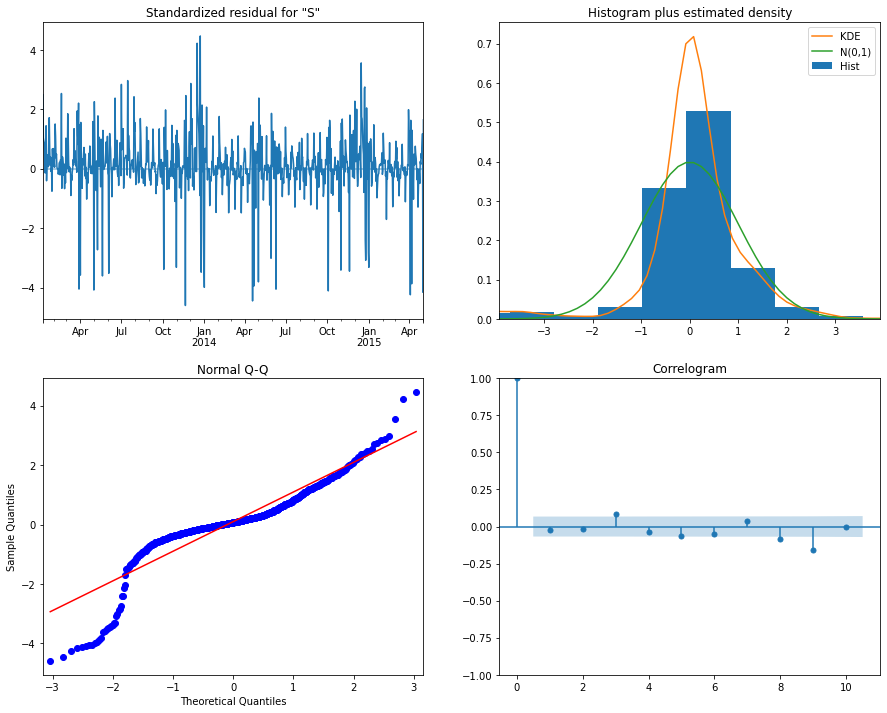

In [205]:
model.plot_diagnostics(figsize=(15,12))

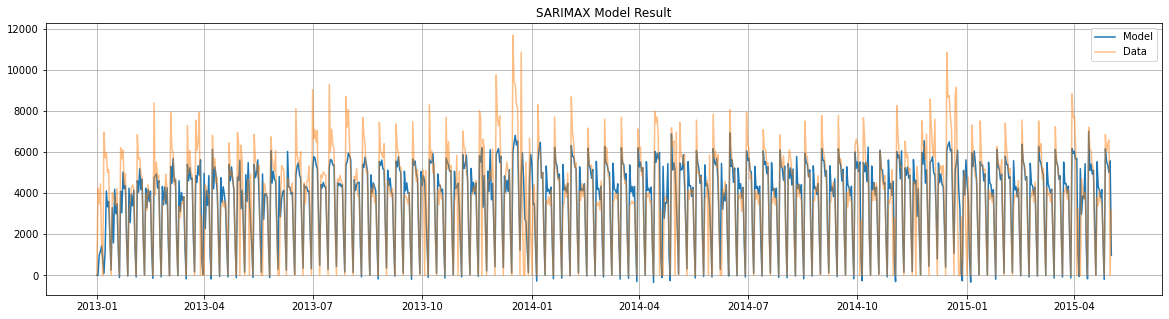

In [213]:
hist_preds = model.predict()
plt.figure(figsize = (20, 5))
plt.plot(hist_preds, label = 'Model')
plt.plot(sales_hist, label = 'Data', alpha = 0.5)
plt.legend()
plt.grid()
plt.title('SARIMAX Model Result');

In [207]:
future_preds = model.forecast(steps = len(sales_future))
future_preds = future_preds.to_frame()
future_preds = future_preds.set_index(sales_future.index)
future_preds

,predicted_mean
Date,
2015-05-03,-117.044695
2015-05-04,5513.707643
2015-05-05,4772.122646
2015-05-06,4634.597160
2015-05-07,3924.024391
...,...
2015-07-27,5805.098623
2015-07-28,5027.322228
2015-07-29,4964.969960


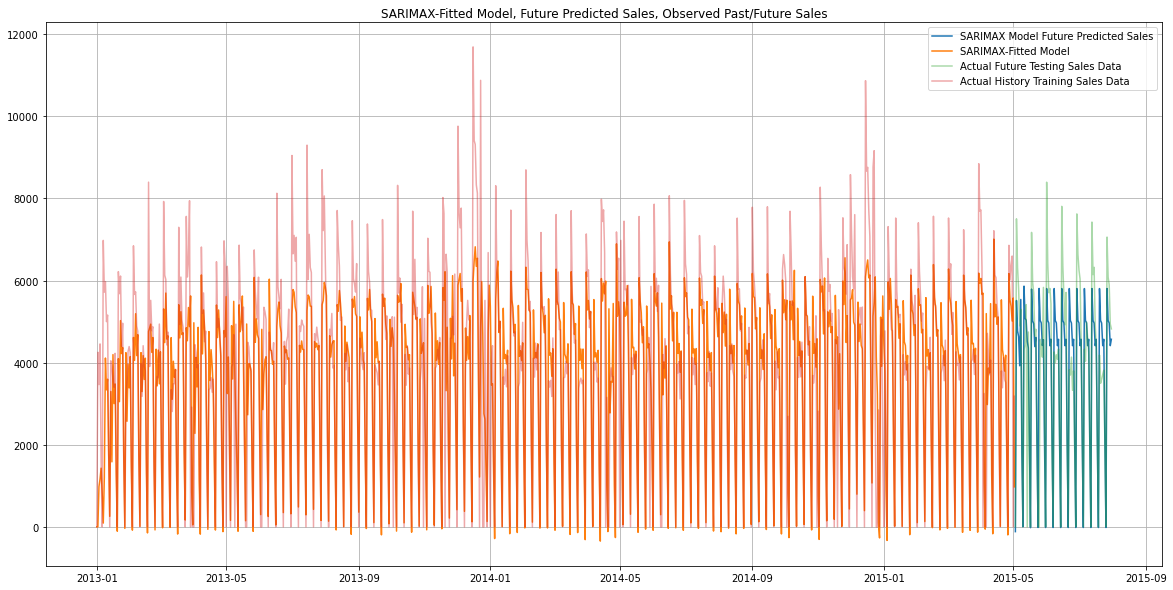

In [221]:
plt.figure(figsize = (20, 10))
plt.plot(future_preds, label = 'SARIMAX Model Future Predicted Sales')
plt.plot(hist_preds, label = 'SARIMAX-Fitted Model')
plt.plot(sales_future, label = 'Actual Future Testing Sales Data', alpha = 0.4)
plt.plot(sales_hist, label = 'Actual History Training Sales Data', alpha = 0.4)
plt.legend()
plt.grid()
plt.title('SARIMAX-Fitted Model, Future Predicted Sales, Observed Past/Future Sales');

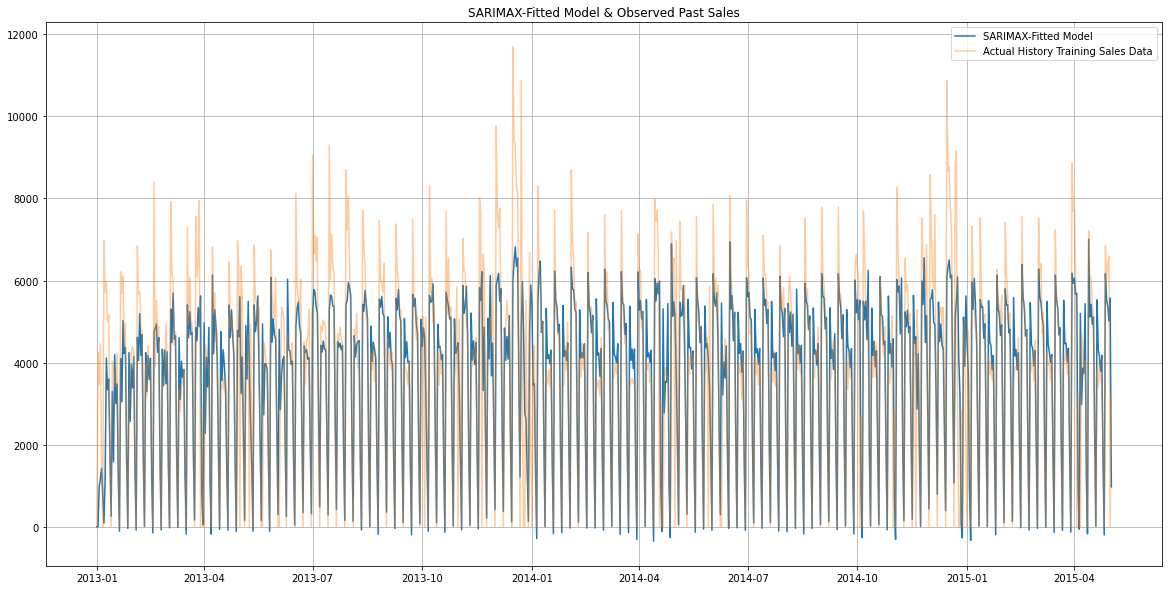

In [220]:
plt.figure(figsize = (20, 10))
plt.plot(hist_preds, label = 'SARIMAX-Fitted Model')
plt.plot(sales_hist, label = 'Actual History Training Sales Data', alpha = 0.4)
plt.legend()
plt.grid()
plt.title('SARIMAX-Fitted Model & Observed Past Sales');

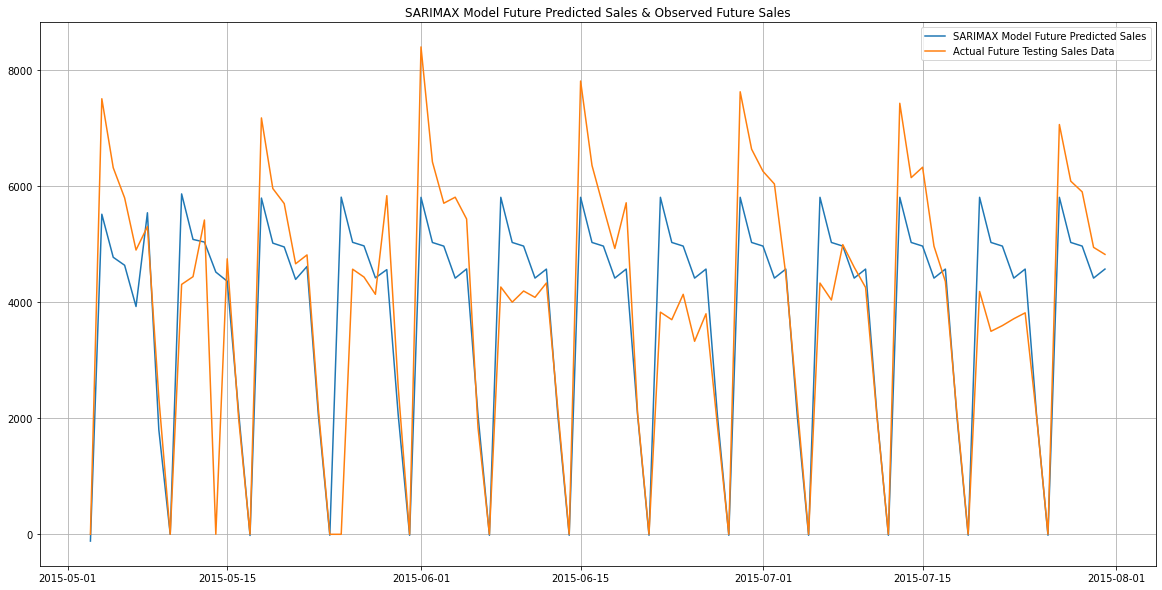

In [210]:
plt.figure(figsize = (20, 10))
plt.plot(future_preds, label = 'SARIMAX Model Future Predicted Sales')
plt.plot(sales_future, label = 'Actual Future Testing Sales Data')
plt.legend()
plt.grid()
plt.title('SARIMAX Model Future Predicted Sales & Observed Future Sales');

In [191]:
sales_future

,Sales
Date,
2015-05-03,0
2015-05-04,7503
2015-05-05,6315
2015-05-06,5795
2015-05-07,4897
...,...
2015-07-27,7059
2015-07-28,6083
2015-07-29,5899


In [192]:
future_preds

,predicted_mean
Date,
2015-05-03,-1334.134909
2015-05-04,5257.899633
2015-05-05,4424.701552
2015-05-06,4232.361952
2015-05-07,3453.179296
...,...
2015-07-27,4270.101619
2015-07-28,3760.489765
2015-07-29,3510.260799


In [228]:
forecast_error = sales_future['Sales'] - future_preds['predicted_mean']
e1 = forecast_error.abs().mean()
e2 = np.sqrt(forecast_error.pow(2).mean())

print("Mean Absolute Error",e1)
print("Root Mean Squared Error",e2)

Mean Absolute Error 827.6904255925241
Root Mean Squared Error 1227.9805636421988


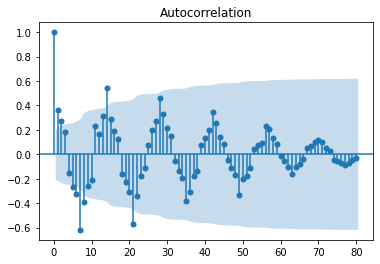

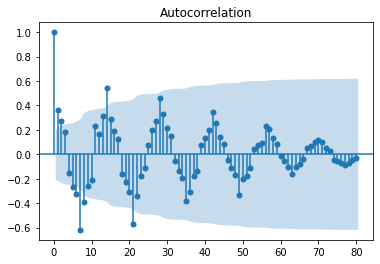

In [223]:
plot_acf(forecast_error, lags =80)